# NLP Final Project Part IV: Analysis of articles with negative sentiment
Identify top reasons for failing data science initiatives (negative sentiment) - these can be related to technology, people, data availability, etc.
Suggest corrective actions

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import requests
import nltk as nltk
import nltk.corpus  
from nltk.text import Text
import pandas as pd
import re
import sys
import matplotlib.pyplot as plt
import spacy 
from spacy import displacy

In [3]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = "/content/drive/MyDrive/Colab Notebooks/V2_nlp_final_project_data/neg_text_custom.csv"
df= pd.read_csv(path,lineterminator='\n')

In [6]:
df.shape

(113335, 5)

In [7]:
# keep only letters, periods, and white space
df["clean_text"] = df["clean_text"].apply(lambda x: re.sub(r'[^a-zA-Z.\s]', '',x))
# remove stop words
stopwords = nltk.corpus.stopwords.words('english')
df["clean_text"] = df["clean_text"].apply(lambda x: ' '.join([word for word in x.split()if word not in (stopwords)]))

In [8]:
df.head(2)

,date,clean_title,clean_text,sentiment,sentiment_category
0,2022-03-09,Gender Bias in Artificial Intelligence | Busin...,Gender Bias Artificial Intelligence Business N...,0,Negative
1,2017-07-04,Big pharma turns to AI to speed drug discovery...,Big pharma turns AI speed drug discovery GSK s...,0,Negative


# Article Text Analysis
## Spacy
Negative sentiment data from custom logistic regression classifier

In [9]:
!python3 -m spacy download en_core_web_lg

2022-11-26 07:24:16.408085: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 13 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [10]:
nlp = spacy.load("en_core_web_lg")

In [11]:
entities = []
labels = []
position_start = []
position_end = []

for line in df["clean_text"]:
    doc = nlp(line)
    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
        position_start.append(ent.start_char)
        position_end.append(ent.end_char)
    
df_spacy_custom = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})

In [12]:
df_spacy_custom.to_csv("spacy_negative_custom_classifier.csv", index = False)

In [36]:
path = "/content/drive/MyDrive/Colab Notebooks/V2_nlp_model_output/spacy_negative_custom_classifier.csv"
df_spacy_custom= pd.read_csv(path,lineterminator='\n')

In [37]:
# exclude these words
Search_List =  ['AI', 'ai', 'artifical intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'DATA SCIENCE']

In [39]:
# orgnization
org_df = df_spacy_custom[df_spacy_custom["Labels"]=="ORG"]
org_df["Entities"] = org_df["Entities"].apply(str)
org_df= org_df[~org_df['Entities'].str.contains('|'.join(Search_List), case=False)]
count_df_spacy_org_text = org_df.groupby("Entities").count().sort_values(by = "Labels", ascending = False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
# person
person_df = df_spacy_custom[df_spacy_custom["Labels"]=="PERSON"]
person_df["Entities"] = person_df["Entities"].apply(str)
person_df= person_df[~person_df['Entities'].str.contains('|'.join(Search_List), case=False)]
count_df_spacy_person_text = person_df.groupby("Entities").count().sort_values(by = "Labels", ascending = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
# location
loc_df = df_spacy_custom[df_spacy_custom["Labels"]=="LOC"]
loc_df = loc_df[~loc_df['Entities'].str.contains('|'.join(Search_List), case=False)]
count_df_spacy_loc_text = loc_df.groupby("Entities").count().sort_values(by = "Labels", ascending = False)

In [41]:
count_df_spacy_org_top_20 = count_df_spacy_org_text.sort_values(by = ['Labels'], ascending = False).head(20).rename(columns = {"Labels":"Count"})
count_df_spacy_org_top_20[["Count"]]

,Count
Entities,
Google,42475
Facebook,19445
Microsoft,17626
Amazon,15257
IBM,12235
Apple,8941
Tesla,6951
Intel,6863
NewscastsPress,6847


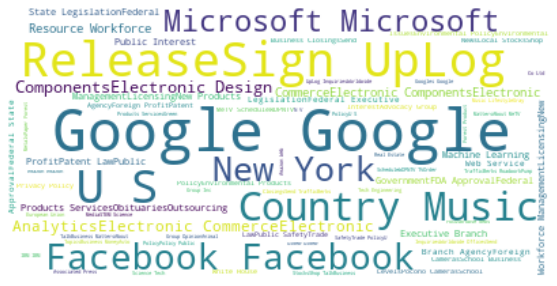

In [18]:
text = " ".join(entities for entities in org_df.Entities)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['AI', 'ai', 'artifical intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'DATA SCIENCE'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [44]:
count_df_spacy_person_top_20 = count_df_spacy_person_text.sort_values(by = ['Labels'], ascending = False).head(20).rename(columns = {"Labels":"Count"})
count_df_spacy_person_top_20[["Count"]]

,Count
Entities,
HardwareComputer,7990
Trump,5049
Elon Musk,4653
TransactionsResidential Real,4346
UsContact,3927
Greta Van SusterenCircle Country Music LifestyleGray,3805
Forbes,3535
Musk,3418
storyInternshipsMeet,3108


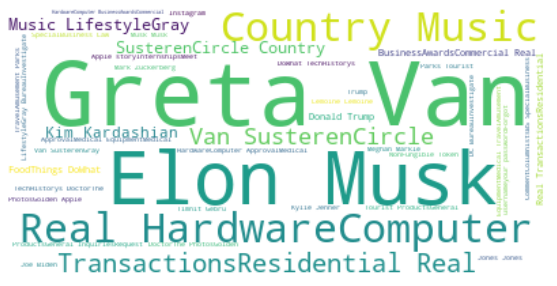

In [20]:
text = " ".join(entities for entities in person_df.Entities.apply(str))

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['AI', 'ai', 'artifical intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'DATA SCIENCE'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [46]:
count_df_spacy_loc_top_20 = count_df_spacy_loc_text.sort_values(by = ['Labels'], ascending = False).head(20).rename(columns = {"Labels":"Count"})
count_df_spacy_loc_top_20[["Count"]]

,Count
Entities,
Europe,5855
North America,3719
Silicon Valley,2739
Earth,2423
Asia,2377
Africa,2243
Lehigh Valley,2145
NYC,1707
Latin America,1598


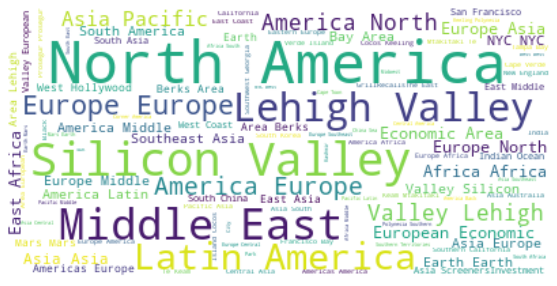

In [47]:
text = " ".join(entities for entities in loc_df.Entities.apply(str))

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['AI', 'ai', 'artifical intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'DATA SCIENCE'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Article Title Analysis
### Spacy

In [23]:
nlp = spacy.load("en_core_web_lg")

In [24]:
entities = []
labels = []
position_start = []
position_end = []

for line in df["clean_title"]:
    doc = nlp(line)
    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
        position_start.append(ent.start_char)
        position_end.append(ent.end_char)
    
df_spacy_custom_title = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})

In [25]:
df_spacy_custom_title.to_csv("spacy_negative_custom_classifier_title.csv", index = False)

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/V2_nlp_model_output/spacy_negative_custom_classifier_title.csv"
df_spacy_custom_title= pd.read_csv(path,lineterminator='\n')

In [26]:
# orgnization
org_df = df_spacy_custom_title[df_spacy_custom_title["Labels"]=="ORG"]
org_df= org_df[~org_df['Entities'].str.contains('|'.join(Search_List), case=False)]
count_df_spacy_org_text = org_df.groupby("Entities").count().sort_values(by = "Labels", ascending = False)

In [27]:
# person
person_df = df_spacy_custom_title[df_spacy_custom_title["Labels"]=="PERSON"]
person_df= person_df[~person_df['Entities'].str.contains('|'.join(Search_List), case=False)]
count_df_spacy_person_text = person_df.groupby("Entities").count().sort_values(by = "Labels", ascending = False)

In [28]:
# location
loc_df = df_spacy_custom_title[df_spacy_custom_title["Labels"]=="LOC"]
loc_df = loc_df[~loc_df['Entities'].str.contains('|'.join(Search_List), case=False)]
count_df_spacy_loc_text = loc_df.groupby("Entities").count().sort_values(by = "Labels", ascending = False)

In [29]:
count_df_spacy_org_top_20 = count_df_spacy_org_text.sort_values(by = ['Labels'], ascending = False).head(20)
count_df_spacy_org_top_20[["Labels"]]

,Labels
Entities,
Google,5029
Microsoft,2741
IBM,2569
Facebook,1510
Amazon,1282
Intel,1159
TechRadar,1054
Nvidia,650
IBM Corporation,586


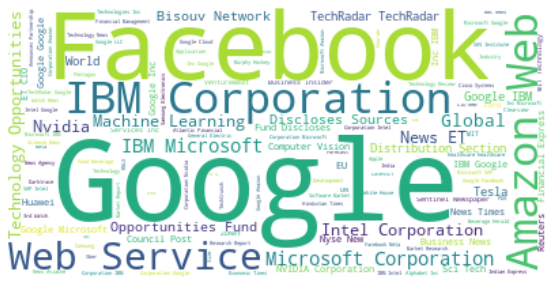

In [30]:
text = " ".join(entities for entities in org_df.Entities)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['AI', 'ai', 'artifical intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'DATA SCIENCE'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [31]:
count_df_spacy_person_top_20 = count_df_spacy_person_text.sort_values(by = ['Labels'], ascending = False).head(20)
count_df_spacy_person_top_20[["Labels"]]

,Labels
Entities,
Elon Musk,454
Murphy,267
Galus Australis,154
Timnit Gebru,131
Biden,91
Forbes,80
Monroe Scoop,79
Trump,79
Zuckerberg,79


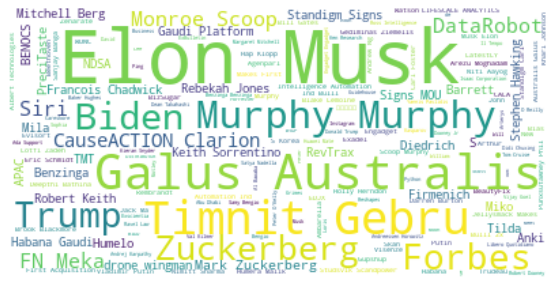

In [32]:
text = " ".join(entities for entities in person_df.Entities.apply(str))

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['AI', 'ai', 'artifical intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'DATA SCIENCE'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [33]:
count_df_spacy_loc_top_20 = count_df_spacy_loc_text.sort_values(by = ['Labels'], ascending = False).head(20)
count_df_spacy_loc_top_20[["Labels"]]

,Labels
Entities,
North America,758
Europe,172
Africa,129
Asia,75
Earth,43
Zenseact,36
| South China,36
Silicon Valley,32
Clinch,25


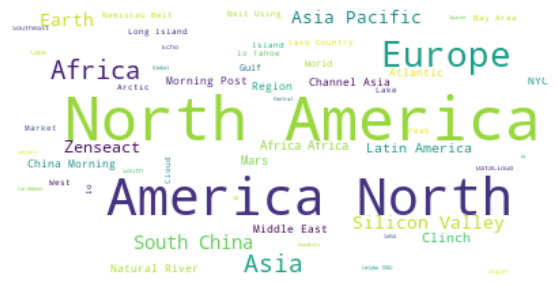

In [34]:
text = " ".join(entities for entities in loc_df.Entities.apply(str))

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['AI', 'ai', 'artifical intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'DATA SCIENCE'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()